In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
from sklearn.utils import check_random_state
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.style.use('ggplot')
y_label_dict = {"se": "平均二乗誤差", "bias": "二乗バイアス", "variance": "バリアンス", "selection": "方策選択"}

from dataset import generate_synthetic_data, calc_true_value
from estimators import calc_online, calc_ips, calc_new
from utils import eps_greedy_policy, softmax_policy, aggregate_simulation_results

In [2]:
## シミュレーション設定
num_runs = 1000 # シミュレーションの繰り返し回数
dim_context = 10 # 特徴量xの次元
num_data = 500 # ログデータのサイズ
num_actions = 4 # 行動数, |A|
T = 12 # 総時点数
eps = 0.0 # データ収集方策のパラメータ, これは共通サポートの仮定を満たさない
beta = -5 # 評価方策のパラメータ
random_state = 12345
random_ = check_random_state(random_state)
num_data_list = [250, 500, 1000, 2000, 4000] # ログデータのサイズ

In [3]:
def run_simulation():
    ## 期待報酬関数を定義するためのパラメータを抽出
    random_ = check_random_state(random_state)
    theta = random_.normal(size=(dim_context, num_actions))
    M = random_.normal(size=(dim_context, num_actions))
    b = random_.normal(size=(1, num_actions))
    W = random_.uniform(0, 1, size=(T, T))
    ## データ収集方策と評価方策の真の性能(policy value)を近似
    policy_value_of_pi0, policy_value_of_pi = calc_true_value(
        dim_context=dim_context, num_actions=num_actions,
        theta=theta, M=M, b=b, W=W, T=T, beta=beta, eps=eps,
    )

    estimated_policy_value_list, selection_result_list = [], []
    for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data(
            num_data=num_data, dim_context=dim_context, num_actions=num_actions,
            theta=theta, M=M, b=b, W=W, T=T, eps=eps, random_state=_
        )
        online_experiment_data = generate_synthetic_data(
            num_data=num_data, dim_context=dim_context, num_actions=num_actions,
            theta=theta, M=M, b=b, W=W, T=1, beta=beta, is_online=True, random_state=_
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = softmax_policy(beta * offline_logged_data["base_q_func"])

        ## ログデータを用いてオフ方策評価を実行する
        estimated_policy_values, selection_result = dict(), dict()
        V_hat_online, selection_result_online = calc_online(online_experiment_data)
        estimated_policy_values["online"] = V_hat_online
        selection_result["online"] = selection_result_online
        V_hat_ips, selection_result_ips = calc_ips(offline_logged_data, pi)
        estimated_policy_values["ips"] = V_hat_ips
        selection_result["ips"] = selection_result_ips
        V_hat_new, selection_result_new = calc_new(offline_logged_data, online_experiment_data, pi)
        estimated_policy_values["new"] = V_hat_new
        selection_result["new"] = selection_result_new
        estimated_policy_value_list.append(estimated_policy_values)
        selection_result_list.append(selection_result)
    return estimated_policy_value_list, selection_result_list, policy_value_of_pi, num_data

In [4]:
result_df_list = []
for num_data in num_data_list:
    estimated_policy_value_list, selection_result_list, policy_value_of_pi, num_data = run_simulation()

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, selection_result_list,
            policy_value_of_pi, "num_data", num_data,
        )
    )
result_df_data = pd.concat(result_df_list).reset_index(level=0)

num_data=4000...: 100%|██████████| 1000/1000 [01:41<00:00,  9.82it/s]


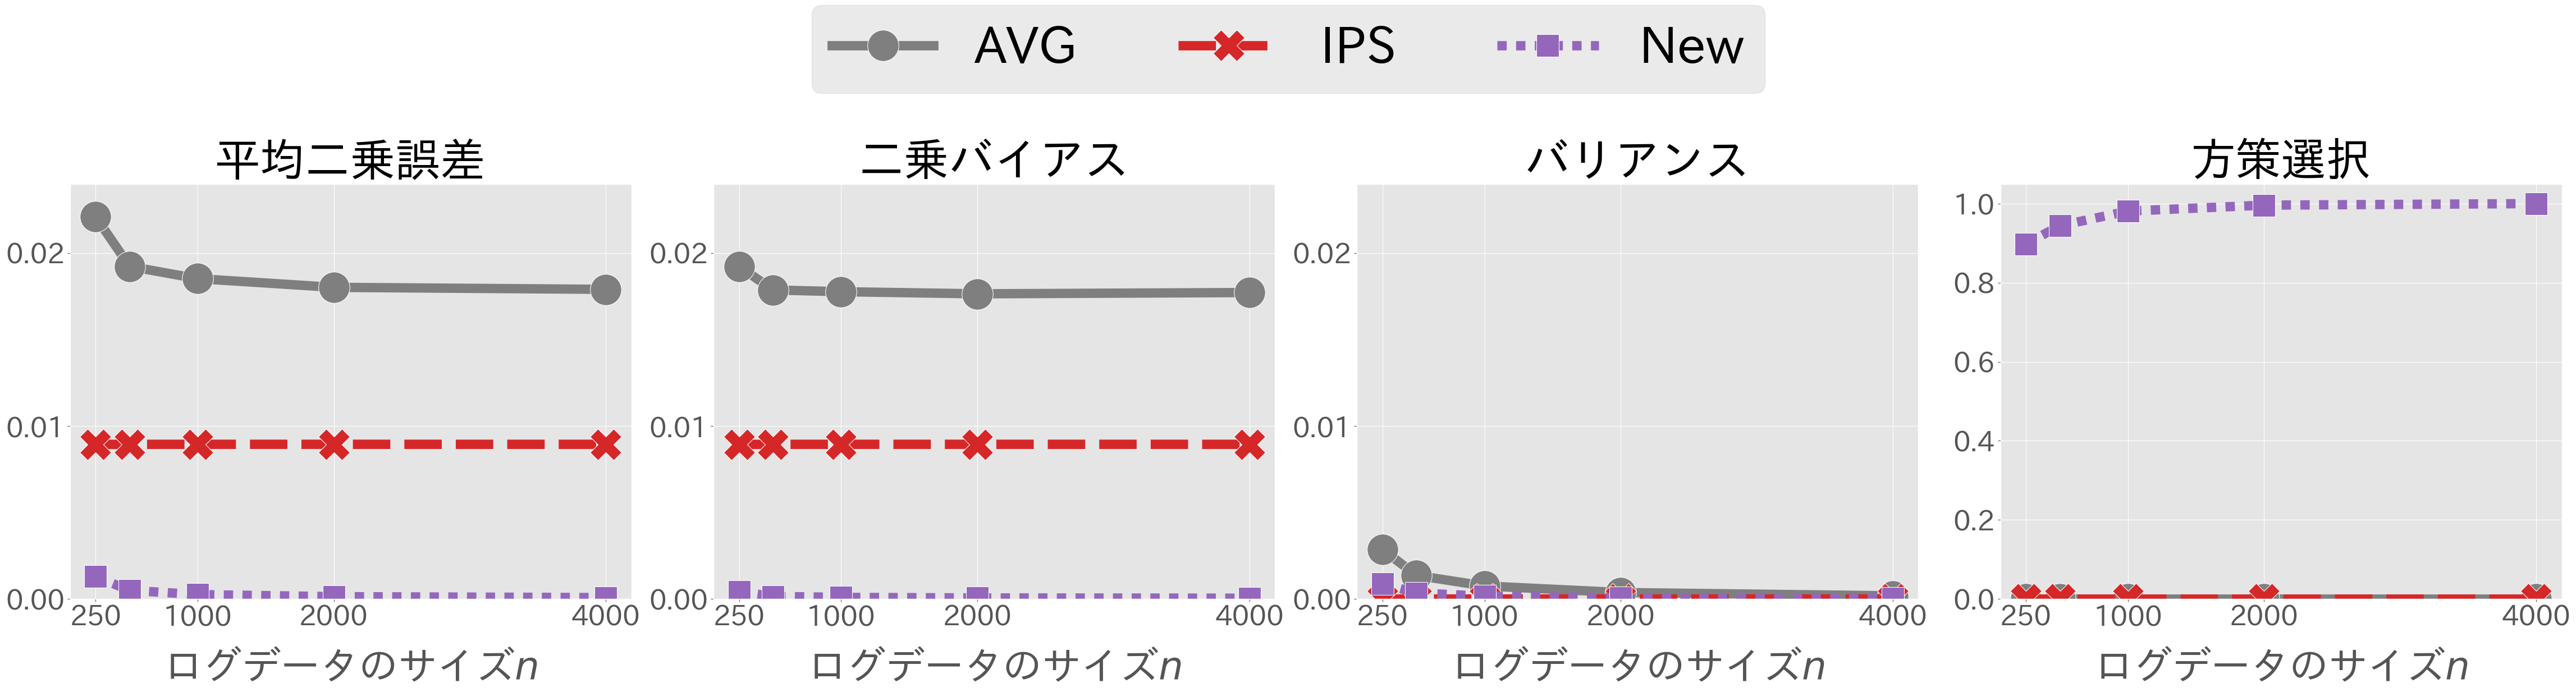

In [6]:
fig, ax_list = plt.subplots(1, 4, figsize=(46, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance", "selection"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=12,
        legend=False,
        style="est",
        x="num_data",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:grey", "tab:red", "tab:purple"],
        data=result_df_data,
    )
    ax.set_title(y_label_dict[y], fontsize=58)
    # yaxis
    ax.set_ylabel("")
    if i < 3:
        ax.set_ylim(0, 0.024)
        ax.set_yticks([0.0, 0.01, 0.02])
    else:
        ax.set_yscale("linear")
        ax.set_ylim(0.0, 1.05)
    ax.tick_params(axis="y", labelsize=35)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xlabel(r"ログデータのサイズ$n$", fontsize=50)
    ax.set_xticks([250, 1000, 2000, 4000])
    ax.set_xticklabels([250, 1000, 2000, 4000], fontsize=35)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["AVG", "IPS", "New"], fontsize=65, bbox_to_anchor=(0.5, 1.15), ncol=5, loc="center")